# Perform error analysis across collaborative tests and activities.


In [1]:
from justhink_problem.problem import init_problem, reset_problem
from justhink_problem.domain.state import WorldState
import pathlib as pl
import pickle
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import wilcoxon, shapiro, ttest_rel
#import cliffs delta
from effsize.effsize import two_group_difference

# Define paths.

In [2]:
processed_tables_pickle_file = pl.Path(
    '../processed_data/processed_tables.pickle')

# Load pickled data.

In [3]:
with processed_tables_pickle_file.open('rb') as handle:
    processed_tables = pickle.load(handle)

In [4]:
processed_tables.keys()
pd.options.display.max_columns = None
df = processed_tables[10]
df = df.loc[df['header.frame_id'] == 'collab-activity-2']
df

,Time,header.seq,header.frame_id,state.edges,state.suggested.u,state.suggested.v,state.terminal,state.submit_suggested,action.agent_name,action.type,action.edge.u,action.edge.v,next_state.edges,next_state.suggested.u,next_state.suggested.v,next_state.terminal,next_state.submit_suggested,action_no,step_no,turn_agent,world_state,action,is_submission,cost,is_mst
98,1148.278606,99,collab-activity-2,[],-1,-1,False,False,robot,0,0,3,[],0,3,False,False,0,1,human,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)","suggest-pick(0,3)",False,0,False
99,1151.976628,100,collab-activity-2,[],0,3,False,False,human,7,-1,-1,[],-1,-1,False,False,1,1,human,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)",disagree,False,0,False
100,1164.458253,101,collab-activity-2,[],-1,-1,False,False,human,0,7,6,[],7,6,False,False,2,1,robot,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)","suggest-pick(7,6)",False,0,False
101,1175.300851,102,collab-activity-2,[],7,6,False,False,robot,0,7,6,[u: 7\nv: 6],-1,-1,False,False,3,1,robot,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)","suggest-pick(7,6)",False,0,False
102,1184.124874,103,collab-activity-2,[u: 7\nv: 6],-1,-1,False,False,robot,0,6,4,[u: 7\nv: 6],6,4,False,False,4,1,human,"WorldState(n:10,e:20|e:1,c:3,s:False,t:False)","suggest-pick(6,4)",False,3,False
103,1185.938908,104,collab-activity-2,[u: 7\nv: 6],6,4,False,False,human,6,-1,-1,"[u: 7\nv: 6, u: 6\nv: 4]",-1,-1,False,False,5,1,human,"WorldState(n:10,e:20|e:1,c:3,s:False,t:False)",agree,False,3,False
104,1211.245186,105,collab-activity-2,"[u: 7\nv: 6, u: 6\nv: 4]",-1,-1,False,False,human,0,1,2,"[u: 7\nv: 6, u: 6\nv: 4]",1,2,False,False,6,1,robot,"WorldState(n:10,e:20|e:2,c:6,s:False,t:False)","suggest-pick(1,2)",False,6,False
105,1224.448048,106,collab-activity-2,"[u: 7\nv: 6, u: 6\nv: 4]",1,2,False,False,robot,0,1,2,"[u: 1\nv: 2, u: 7\nv: 6, u: 6\nv: 4]",-1,-1,False,False,7,1,robot,"WorldState(n:10,e:20|e:2,c:6,s:False,t:False)","suggest-pick(1,2)",False,6,False
106,1233.681034,107,collab-activity-2,"[u: 1\nv: 2, u: 7\nv: 6, u: 6\nv: 4]",-1,-1,False,False,robot,0,2,3,"[u: 1\nv: 2, u: 6\nv: 4, u: 7\nv: 6]",2,3,False,False,8,1,human,"WorldState(n:10,e:20|e:3,c:9,s:False,t:False)","suggest-pick(2,3)",False,9,False
107,1271.644502,108,collab-activity-2,"[u: 1\nv: 2, u: 6\nv: 4, u: 7\nv: 6]",2,3,False,False,human,6,-1,-1,"[u: 2\nv: 3, u: 1\nv: 2, u: 6\nv: 4, u: 7\nv: 6]",-1,-1,False,False,9,1,human,"WorldState(n:10,e:20|e:3,c:9,s:False,t:False)",agree,False,9,False


# 1 Error over collab activity success.

### Cleaning Tables.

In [20]:
# formatting dataframe for error over best collaborative activity success
def clean_tables():
    student_tables = {}
    for student, df in processed_tables.items():
        #list of maximum error values for each activity
        max_error = []

        df = df.copy()
        df = df[df['is_submission']]

        df.drop(['Time', 'header.seq', 'state.edges', 'state.suggested.u', 'state.suggested.v', 'state.terminal', 'state.submit_suggested', 'action.type', 'action.edge.u', 'action.edge.v', 'turn_agent', 'next_state.edges', 'next_state.suggested.u', 'next_state.suggested.v',
                'next_state.terminal', 'next_state.submit_suggested', 'action_no', 'step_no'], axis=1, inplace=True)

        # removing collaborative activity rows
#         df = df[df['header.frame_id'] != "collab-activity"]
#         df = df[df['header.frame_id'] != "collab-activity-2"]
        # removing duplicate rows from submission log and keeping the last submission
#         df.drop_duplicates(subset="header.frame_id",
#                            keep='last', inplace=True)

        # preserving collaborative activity rows while removing duplicate test rows
        df = pd.concat([
            df[df['header.frame_id'] == 'collab-activity'],
            df[df['header.frame_id'] == 'collab-activity-2'],
            df[(df['header.frame_id'] != 'collab-activity') & (df['header.frame_id'] !=
                                                               'collab-activity-2')].drop_duplicates(['header.frame_id'], keep='last')
        ])

        mst_costs = []
        spanning = []
        norm_error = []

        for i, row in df.iterrows():
            cost = row['world_state'].get_mst_cost()
            span = row['world_state'].is_spanning()
            mst_costs.append(cost)
            spanning.append(span)
            # compute normalized error
            if span:
                norm_error.append((int(row['cost']) - int(row['world_state'].get_mst_cost())) /
                                  int(row['world_state'].get_mst_cost()))
                max_error.append((int(row['world_state'].get_max_cost()) - int(row['world_state'].get_mst_cost())) /
                                  int(row['world_state'].get_mst_cost()))
            else:
                norm_error.append(None)

        # adding mst_cost, spanning, and normalized_error columns
        df['mst_cost'] = mst_costs
        df['spanning'] = spanning
        df['normalized_error'] = norm_error

        student_tables[student] = df

        print("STUDENT", student)
        display(df)
    return student_tables, max_error


all_tables, max_error = clean_tables()
print(max_error)

STUDENT 6


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
93,collab-activity,human,"WorldState(n:10,e:20|e:14,c:39,s:True,t:False)",submit,True,39,False,22,True,0.772727
103,collab-activity,robot,"WorldState(n:10,e:20|e:2,c:5,s:False,t:False)",submit,True,5,False,22,False,NaN
109,collab-activity,robot,"WorldState(n:10,e:20|e:2,c:5,s:False,t:False)",submit,True,5,False,22,False,NaN
118,collab-activity,robot,"WorldState(n:10,e:20|e:3,c:8,s:False,t:False)",submit,True,8,False,22,False,NaN
153,collab-activity,human,"WorldState(n:10,e:20|e:14,c:39,s:True,t:False)",submit,True,39,False,22,True,0.772727
181,collab-activity-2,human,"WorldState(n:10,e:20|e:12,c:54,s:True,t:False)",submit,True,54,False,35,True,0.542857
182,collab-activity-2,human,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)",submit,True,0,False,35,False,NaN
211,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:39,s:False,t:False)",submit,True,39,False,35,False,NaN
231,collab-activity-2,human,"WorldState(n:10,e:20|e:5,c:15,s:False,t:False)",submit,True,15,False,35,False,NaN
12,pretest-1,human,"WorldState(n:7,e:12|e:7,c:19,s:True,t:False)",suggest-submit,True,19,False,15,True,0.266667


STUDENT 1


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
81,collab-activity,robot,"WorldState(n:10,e:20|e:14,c:38,s:True,t:False)",submit,True,38,False,22,True,0.727273
105,collab-activity,human,"WorldState(n:10,e:20|e:11,c:29,s:True,t:False)",submit,True,29,False,22,True,0.318182
128,collab-activity,robot,"WorldState(n:10,e:20|e:11,c:29,s:True,t:False)",submit,True,29,False,22,True,0.318182
155,collab-activity,human,"WorldState(n:10,e:20|e:12,c:32,s:True,t:False)",submit,True,32,False,22,True,0.454545
185,collab-activity-2,robot,"WorldState(n:10,e:20|e:11,c:47,s:False,t:False)",submit,True,47,False,35,False,NaN
220,collab-activity-2,human,"WorldState(n:10,e:20|e:11,c:47,s:True,t:False)",submit,True,47,False,35,True,0.342857
245,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:35,s:True,t:False)",submit,True,35,True,35,True,0.000000
12,pretest-1,human,"WorldState(n:7,e:12|e:7,c:23,s:True,t:False)",suggest-submit,True,23,False,15,True,0.533333
21,pretest-2,human,"WorldState(n:7,e:12|e:7,c:38,s:True,t:False)",suggest-submit,True,38,False,30,True,0.266667
30,pretest-3,human,"WorldState(n:7,e:12|e:6,c:22,s:True,t:False)",suggest-submit,True,22,False,21,True,0.047619


STUDENT 9


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
109,collab-activity,human,"WorldState(n:10,e:20|e:12,c:32,s:True,t:False)",submit,True,32,False,22,True,0.454545
143,collab-activity,human,"WorldState(n:10,e:20|e:14,c:38,s:True,t:False)",submit,True,38,False,22,True,0.727273
167,collab-activity,human,"WorldState(n:10,e:20|e:9,c:23,s:True,t:False)",submit,True,23,False,22,True,0.045455
196,collab-activity,robot,"WorldState(n:10,e:20|e:13,c:35,s:True,t:False)",submit,True,35,False,22,True,0.590909
225,collab-activity-2,human,"WorldState(n:10,e:20|e:11,c:47,s:True,t:False)",submit,True,47,False,35,True,0.342857
253,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:35,s:True,t:False)",submit,True,35,True,35,True,0.000000
15,pretest-1,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",suggest-submit,True,18,False,15,True,0.200000
29,pretest-2,human,"WorldState(n:7,e:12|e:12,c:78,s:True,t:False)",suggest-submit,True,78,False,30,True,1.600000
45,pretest-3,human,"WorldState(n:7,e:12|e:12,c:51,s:True,t:False)",suggest-submit,True,51,False,21,True,1.428571
59,pretest-4,human,"WorldState(n:7,e:12|e:12,c:99,s:True,t:False)",suggest-submit,True,99,False,45,True,1.200000


STUDENT 7


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
65,collab-activity,human,"WorldState(n:10,e:20|e:7,c:16,s:False,t:False)",submit,True,16,False,22,False,NaN
93,collab-activity,human,"WorldState(n:10,e:20|e:9,c:22,s:True,t:False)",submit,True,22,True,22,True,0.0
116,collab-activity-2,human,"WorldState(n:10,e:20|e:6,c:20,s:False,t:False)",submit,True,20,False,35,False,NaN
143,collab-activity-2,human,"WorldState(n:10,e:20|e:6,c:22,s:False,t:False)",submit,True,22,False,35,False,NaN
160,collab-activity-2,human,"WorldState(n:10,e:20|e:6,c:22,s:False,t:False)",submit,True,22,False,35,False,NaN
180,collab-activity-2,human,"WorldState(n:10,e:20|e:7,c:25,s:False,t:False)",submit,True,25,False,35,False,NaN
23,pretest-1,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",suggest-submit,True,18,False,15,True,0.2
31,pretest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",suggest-submit,True,30,True,30,True,0.0
37,pretest-3,human,"WorldState(n:7,e:12|e:3,c:12,s:False,t:False)",suggest-submit,True,12,False,21,False,NaN
41,pretest-4,human,"WorldState(n:7,e:12|e:2,c:14,s:False,t:False)",suggest-submit,True,14,False,45,False,NaN


STUDENT 2


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
116,collab-activity,human,"WorldState(n:10,e:20|e:9,c:22,s:True,t:False)",submit,True,22,True,22,True,0.000000
143,collab-activity-2,human,"WorldState(n:10,e:20|e:10,c:42,s:True,t:False)",submit,True,42,False,35,True,0.200000
144,collab-activity-2,human,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)",submit,True,0,False,35,False,NaN
145,collab-activity-2,human,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)",submit,True,0,False,35,False,NaN
146,collab-activity-2,human,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)",submit,True,0,False,35,False,NaN
147,collab-activity-2,human,"WorldState(n:10,e:20|e:0,c:0,s:False,t:False)",submit,True,0,False,35,False,NaN
178,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:35,s:True,t:False)",submit,True,35,True,35,True,0.000000
6,pretest-1,human,"WorldState(n:7,e:12|e:1,c:4,s:False,t:False)",suggest-submit,True,4,False,15,False,NaN
25,pretest-2,human,"WorldState(n:7,e:12|e:7,c:48,s:True,t:False)",suggest-submit,True,48,False,30,True,0.600000
34,pretest-3,human,"WorldState(n:7,e:12|e:7,c:27,s:True,t:False)",suggest-submit,True,27,False,21,True,0.285714


STUDENT 5


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
104,collab-activity,robot,"WorldState(n:10,e:20|e:14,c:38,s:True,t:False)",submit,True,38,False,22,True,0.727273
141,collab-activity,robot,"WorldState(n:10,e:20|e:12,c:31,s:True,t:False)",submit,True,31,False,22,True,0.409091
174,collab-activity,human,"WorldState(n:10,e:20|e:11,c:29,s:True,t:False)",submit,True,29,False,22,True,0.318182
203,collab-activity,human,"WorldState(n:10,e:20|e:8,c:19,s:False,t:False)",submit,True,19,False,22,False,NaN
240,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:35,s:True,t:False)",submit,True,35,True,35,True,0.000000
22,pretest-1,human,"WorldState(n:7,e:12|e:8,c:22,s:True,t:False)",suggest-submit,True,22,False,15,True,0.466667
31,pretest-2,human,"WorldState(n:7,e:12|e:7,c:38,s:True,t:False)",suggest-submit,True,38,False,30,True,0.266667
40,pretest-3,human,"WorldState(n:7,e:12|e:7,c:25,s:True,t:False)",suggest-submit,True,25,False,21,True,0.190476
56,pretest-4,human,"WorldState(n:7,e:12|e:8,c:62,s:True,t:False)",suggest-submit,True,62,False,45,True,0.377778
65,pretest-5,human,"WorldState(n:7,e:12|e:7,c:18,s:True,t:False)",suggest-submit,True,18,False,15,True,0.200000


STUDENT 4


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
78,collab-activity,human,"WorldState(n:10,e:20|e:12,c:32,s:True,t:False)",submit,True,32,False,22,True,0.454545
111,collab-activity,human,"WorldState(n:10,e:20|e:11,c:29,s:True,t:False)",submit,True,29,False,22,True,0.318182
138,collab-activity,human,"WorldState(n:10,e:20|e:11,c:30,s:True,t:False)",submit,True,30,False,22,True,0.363636
179,collab-activity,human,"WorldState(n:10,e:20|e:9,c:22,s:False,t:False)",submit,True,22,False,22,False,NaN
202,collab-activity-2,robot,"WorldState(n:10,e:20|e:8,c:30,s:False,t:False)",submit,True,30,False,35,False,NaN
226,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:35,s:False,t:False)",submit,True,35,False,35,False,NaN
253,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:35,s:True,t:False)",submit,True,35,True,35,True,0.000000
7,pretest-1,human,"WorldState(n:7,e:12|e:1,c:2,s:False,t:False)",suggest-submit,True,2,False,15,False,NaN
20,pretest-2,human,"WorldState(n:7,e:12|e:11,c:68,s:True,t:False)",suggest-submit,True,68,False,30,True,1.266667
28,pretest-3,human,"WorldState(n:7,e:12|e:6,c:26,s:True,t:False)",suggest-submit,True,26,False,21,True,0.238095


STUDENT 3


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
79,collab-activity,robot,"WorldState(n:10,e:20|e:11,c:30,s:True,t:False)",submit,True,30,False,22,True,0.363636
108,collab-activity,human,"WorldState(n:10,e:20|e:11,c:29,s:True,t:False)",submit,True,29,False,22,True,0.318182
131,collab-activity,human,"WorldState(n:10,e:20|e:9,c:22,s:True,t:False)",submit,True,22,True,22,True,0.000000
143,collab-activity-2,robot,"WorldState(n:10,e:20|e:5,c:21,s:False,t:False)",submit,True,21,False,35,False,NaN
175,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:37,s:True,t:False)",submit,True,37,False,35,True,0.057143
202,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:39,s:True,t:False)",submit,True,39,False,35,True,0.114286
228,collab-activity-2,robot,"WorldState(n:10,e:20|e:9,c:37,s:True,t:False)",submit,True,37,False,35,True,0.057143
11,pretest-1,human,"WorldState(n:7,e:12|e:6,c:16,s:True,t:False)",suggest-submit,True,16,False,15,True,0.066667
19,pretest-2,human,"WorldState(n:7,e:12|e:6,c:32,s:True,t:False)",suggest-submit,True,32,False,30,True,0.066667
27,pretest-3,human,"WorldState(n:7,e:12|e:6,c:22,s:True,t:False)",suggest-submit,True,22,False,21,True,0.047619


STUDENT 10


,header.frame_id,action.agent_name,world_state,action,is_submission,cost,is_mst,mst_cost,spanning,normalized_error
97,collab-activity,human,"WorldState(n:10,e:20|e:9,c:22,s:True,t:False)",submit,True,22,True,22,True,0.000000
123,collab-activity-2,human,"WorldState(n:10,e:20|e:9,c:35,s:True,t:False)",submit,True,35,True,35,True,0.000000
11,pretest-1,human,"WorldState(n:7,e:12|e:6,c:16,s:True,t:False)",suggest-submit,True,16,False,15,True,0.066667
39,pretest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",suggest-submit,True,30,True,30,True,0.000000
47,pretest-3,human,"WorldState(n:7,e:12|e:6,c:21,s:True,t:False)",suggest-submit,True,21,True,21,True,0.000000
55,pretest-4,human,"WorldState(n:7,e:12|e:6,c:45,s:True,t:False)",suggest-submit,True,45,True,45,True,0.000000
63,pretest-5,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",suggest-submit,True,15,True,15,True,0.000000
131,posttest-1,human,"WorldState(n:7,e:12|e:6,c:15,s:True,t:False)",suggest-submit,True,15,True,15,True,0.000000
141,posttest-2,human,"WorldState(n:7,e:12|e:6,c:30,s:True,t:False)",suggest-submit,True,30,True,30,True,0.000000
149,posttest-3,human,"WorldState(n:7,e:12|e:6,c:22,s:True,t:False)",suggest-submit,True,22,False,21,True,0.047619


[1.9090909090909092, 2.085714285714286, 1.6, 1.6, 1.4285714285714286, 1.2, 1.6, 1.6, 1.6, 1.4285714285714286, 1.2, 1.6]


### Formatting collab submissions dataframe.

In [6]:
# formatting dataframe for collab activities only
cdf = pd.DataFrame()

#dictionary containing all collaborative attempts by each student
collab_attempts = {}

for key, mdf in all_tables.items():
    collab_df = mdf.loc[mdf['header.frame_id'].isin(
        ['collab-activity', 'collab-activity-2'])].copy()
    collab_df['student'] = key
    collab_df.drop(columns=['world_state', 'is_submission', 'is_mst', 'cost', 'mst_cost', 'spanning', 'action'
                            ], inplace=True)
    collab_df.rename(columns={"header.frame_id": "activity",
                     "action.agent_name": "agent", "normalized_error": "error"}, inplace=True)
    cdf = cdf.append(collab_df)
    collab_attempts[key] = collab_df
    
# dataframe containing all collaborative activity submissions 
cdf

,activity,agent,error,student
93,collab-activity,human,0.772727,6
103,collab-activity,robot,NaN,6
109,collab-activity,robot,NaN,6
118,collab-activity,robot,NaN,6
153,collab-activity,human,0.772727,6
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
81,collab-activity,robot,0.727273,1


### Filtering human submissions.

In [7]:
# dataframe containing only human collaborative activity submissions
cdf_human = pd.DataFrame()

# removing robot submissions
for index, row in cdf.iterrows():
    cdf_human = cdf.loc[cdf['agent'].isin(
        ['human'])].copy()

display(cdf_human)

# reformatting dataframes with only human submissions so they are activity specific

collab_df_1 = cdf_human.loc[cdf_human['activity'].isin(
    ['collab-activity'])].copy()

collab_df_2 = cdf_human.loc[cdf_human['activity'].isin(
    ['collab-activity-2'])].copy()

display(collab_df_1)
display(collab_df_2)

,activity,agent,error,student
93,collab-activity,human,0.772727,6
153,collab-activity,human,0.772727,6
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
105,collab-activity,human,0.318182,1
155,collab-activity,human,0.454545,1
220,collab-activity-2,human,0.342857,1
245,collab-activity-2,human,0.000000,1


,activity,agent,error,student
93,collab-activity,human,0.772727,6
153,collab-activity,human,0.772727,6
105,collab-activity,human,0.318182,1
155,collab-activity,human,0.454545,1
109,collab-activity,human,0.454545,9
143,collab-activity,human,0.727273,9
167,collab-activity,human,0.045455,9
65,collab-activity,human,NaN,7
93,collab-activity,human,0.000000,7
116,collab-activity,human,0.000000,2


,activity,agent,error,student
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
220,collab-activity-2,human,0.342857,1
245,collab-activity-2,human,0.000000,1
225,collab-activity-2,human,0.342857,9
253,collab-activity-2,human,0.000000,9
116,collab-activity-2,human,NaN,7
143,collab-activity-2,human,NaN,7


### Filtering best submissions.

In [8]:

# making a new dataframe that only contains the best submissions in each activity per student

# takes a dataframe containing rows of submissions and returns a dataframe with the best submissions
def bestDf(df):

    best_df = pd.DataFrame()
    bdf = df.copy()
    current = bdf.iloc[[0][0]]['student']
    temp_dict = {}
    temp_df = pd.DataFrame()

    for index, row in bdf.iterrows():
        #print('current student', current)
        if current == row['student']:
            # compare the errors of every student so that we select the best in each activity
            # add them to a new df
            temp_df = temp_df.append(row)
            # sort based on error value
            temp_df.sort_values(
                by=['error'], inplace=True, ascending=True, na_position='last', ignore_index=True)

            # gets the dataframe row with the lowest error and adds it to a temporary dictionary
            # update dictionary with key as student, value as the temp df where the first row is the best
            temp_dict[current] = temp_df.iloc[0]
            #display(temp_df)
        else:
            current = row['student']
            temp_df = pd.DataFrame()
            
            # figure out how to compare the errors of every student so that we select the best in each activity
            # add them to a new df
            temp_df = temp_df.append(row)
            # sort based on error value
            temp_df.sort_values(
                by=['error'], inplace=True, ascending=True, na_position='last', ignore_index=True)

            # gets the dataframe row with the lowest error and adds it to a temporary dictionary
            # update dictionary with key as student, value as the temp df where the first row is the best
            temp_dict[current] = temp_df.iloc[0]
            #display(temp_df)

    # display(temp_dict)

    # now need to loop through the dictionary and for every item, the first row in the value is the best submission
    for student, temp in temp_dict.items():
        # appending best submission to best_df
        # display(temp)
        temp.name = student
        best_df = best_df.append(temp)
    return best_df


bestDf(collab_df_1)

,activity,agent,error,student
6,collab-activity,human,0.772727,6.0
1,collab-activity,human,0.318182,1.0
9,collab-activity,human,0.045455,9.0
7,collab-activity,human,0.000000,7.0
2,collab-activity,human,0.000000,2.0
5,collab-activity,human,0.318182,5.0
4,collab-activity,human,0.318182,4.0
3,collab-activity,human,0.000000,3.0
10,collab-activity,human,0.000000,10.0


### Creating best dataframes for visualization.

In [9]:
collab_dfs = [collab_df_1, collab_df_2]

collab_best = pd.DataFrame()

# creating dataframes with the best submission of each collaborative activity for every student
for df in collab_dfs:
    best = bestDf(df)
    display(best)
    collab_best = collab_best.append(best)

collab_best.drop(columns=['agent'], inplace=True)
collab_best

,activity,agent,error,student
6,collab-activity,human,0.772727,6.0
1,collab-activity,human,0.318182,1.0
9,collab-activity,human,0.045455,9.0
7,collab-activity,human,0.000000,7.0
2,collab-activity,human,0.000000,2.0
5,collab-activity,human,0.318182,5.0
4,collab-activity,human,0.318182,4.0
3,collab-activity,human,0.000000,3.0
10,collab-activity,human,0.000000,10.0


,activity,agent,error,student
6,collab-activity-2,human,0.542857,6.0
1,collab-activity-2,human,0.000000,1.0
9,collab-activity-2,human,0.000000,9.0
7,collab-activity-2,human,NaN,7.0
2,collab-activity-2,human,0.000000,2.0
5,collab-activity-2,human,0.000000,5.0
4,collab-activity-2,human,0.000000,4.0
3,collab-activity-2,human,0.057143,3.0
10,collab-activity-2,human,0.000000,10.0


,activity,error,student
6,collab-activity,0.772727,6.0
1,collab-activity,0.318182,1.0
9,collab-activity,0.045455,9.0
7,collab-activity,0.000000,7.0
2,collab-activity,0.000000,2.0
5,collab-activity,0.318182,5.0
4,collab-activity,0.318182,4.0
3,collab-activity,0.000000,3.0
10,collab-activity,0.000000,10.0
6,collab-activity-2,0.542857,6.0


### Visualization of error over collab activity by best submission.

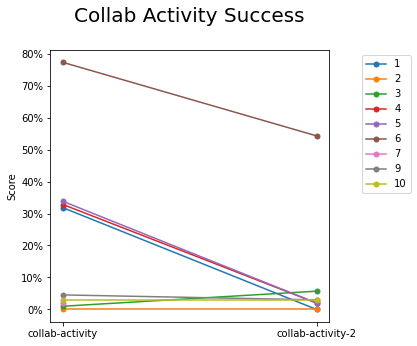

In [10]:
# visualization for error evolution over the best submission in each collaborative activity
students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
separation = 0.01

# graphing the pretest versus posttest is_spanning scores
fig, ax = plt.subplots(1, figsize=(5, 5))

prelist = list()
postlist = list()
for i in students:
    temp = collab_best[collab_best['student'] == i]
    values = list(temp.error)
    #computing offset between overlapping lines
    p0 = values[0] + prelist.count(values[0])*separation
    p1 = values[1] + prelist.count(values[1])*separation
    prelist.append(values[0])
    postlist.append(values[1])
    #plotting
    plt.plot(temp.activity, [p0,p1], marker='o', markersize=5)
plt.ylabel('Score')
plt.title('Collab Activity Success\n', loc='center', fontsize=20)

leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])
plt.show()


# 2 Error over collab activity by attempt.

In [11]:
custom_xticks = {}
for student, df in collab_attempts.items():
    # add attempt number column for graph
    df.reset_index(drop=True, inplace=True)
    df['attempt'] = df.index + 1
    count = 1
    labels = []
    for index, row in df.iterrows():
        if row['activity'] == 'collab-activity-2':
            # attempt = count
            # df.at[index,'attempt'] = attempt
            labels.append(count)
            count += 1
        else:
            labels.append(row['attempt'])
    custom_xticks[student] = labels
    print(custom_xticks)
    display(df)

{6: [1, 2, 3, 4, 5, 1, 2, 3, 4]}


,activity,agent,error,student,attempt
0,collab-activity,human,0.772727,6,1
1,collab-activity,robot,NaN,6,2
2,collab-activity,robot,NaN,6,3
3,collab-activity,robot,NaN,6,4
4,collab-activity,human,0.772727,6,5
5,collab-activity-2,human,0.542857,6,6
6,collab-activity-2,human,NaN,6,7
7,collab-activity-2,human,NaN,6,8
8,collab-activity-2,human,NaN,6,9


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3]}


,activity,agent,error,student,attempt
0,collab-activity,robot,0.727273,1,1
1,collab-activity,human,0.318182,1,2
2,collab-activity,robot,0.318182,1,3
3,collab-activity,human,0.454545,1,4
4,collab-activity-2,robot,NaN,1,5
5,collab-activity-2,human,0.342857,1,6
6,collab-activity-2,human,0.000000,1,7


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3], 9: [1, 2, 3, 4, 1, 2]}


,activity,agent,error,student,attempt
0,collab-activity,human,0.454545,9,1
1,collab-activity,human,0.727273,9,2
2,collab-activity,human,0.045455,9,3
3,collab-activity,robot,0.590909,9,4
4,collab-activity-2,human,0.342857,9,5
5,collab-activity-2,human,0.000000,9,6


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3], 9: [1, 2, 3, 4, 1, 2], 7: [1, 2, 1, 2, 3, 4]}


,activity,agent,error,student,attempt
0,collab-activity,human,NaN,7,1
1,collab-activity,human,0.0,7,2
2,collab-activity-2,human,NaN,7,3
3,collab-activity-2,human,NaN,7,4
4,collab-activity-2,human,NaN,7,5
5,collab-activity-2,human,NaN,7,6


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3], 9: [1, 2, 3, 4, 1, 2], 7: [1, 2, 1, 2, 3, 4], 2: [1, 1, 2, 3, 4, 5, 6]}


,activity,agent,error,student,attempt
0,collab-activity,human,0.0,2,1
1,collab-activity-2,human,0.2,2,2
2,collab-activity-2,human,NaN,2,3
3,collab-activity-2,human,NaN,2,4
4,collab-activity-2,human,NaN,2,5
5,collab-activity-2,human,NaN,2,6
6,collab-activity-2,human,0.0,2,7


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3], 9: [1, 2, 3, 4, 1, 2], 7: [1, 2, 1, 2, 3, 4], 2: [1, 1, 2, 3, 4, 5, 6], 5: [1, 2, 3, 4, 1]}


,activity,agent,error,student,attempt
0,collab-activity,robot,0.727273,5,1
1,collab-activity,robot,0.409091,5,2
2,collab-activity,human,0.318182,5,3
3,collab-activity,human,NaN,5,4
4,collab-activity-2,human,0.000000,5,5


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3], 9: [1, 2, 3, 4, 1, 2], 7: [1, 2, 1, 2, 3, 4], 2: [1, 1, 2, 3, 4, 5, 6], 5: [1, 2, 3, 4, 1], 4: [1, 2, 3, 4, 1, 2, 3]}


,activity,agent,error,student,attempt
0,collab-activity,human,0.454545,4,1
1,collab-activity,human,0.318182,4,2
2,collab-activity,human,0.363636,4,3
3,collab-activity,human,NaN,4,4
4,collab-activity-2,robot,NaN,4,5
5,collab-activity-2,human,NaN,4,6
6,collab-activity-2,human,0.000000,4,7


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3], 9: [1, 2, 3, 4, 1, 2], 7: [1, 2, 1, 2, 3, 4], 2: [1, 1, 2, 3, 4, 5, 6], 5: [1, 2, 3, 4, 1], 4: [1, 2, 3, 4, 1, 2, 3], 3: [1, 2, 3, 1, 2, 3, 4]}


,activity,agent,error,student,attempt
0,collab-activity,robot,0.363636,3,1
1,collab-activity,human,0.318182,3,2
2,collab-activity,human,0.000000,3,3
3,collab-activity-2,robot,NaN,3,4
4,collab-activity-2,human,0.057143,3,5
5,collab-activity-2,human,0.114286,3,6
6,collab-activity-2,robot,0.057143,3,7


{6: [1, 2, 3, 4, 5, 1, 2, 3, 4], 1: [1, 2, 3, 4, 1, 2, 3], 9: [1, 2, 3, 4, 1, 2], 7: [1, 2, 1, 2, 3, 4], 2: [1, 1, 2, 3, 4, 5, 6], 5: [1, 2, 3, 4, 1], 4: [1, 2, 3, 4, 1, 2, 3], 3: [1, 2, 3, 1, 2, 3, 4], 10: [1, 1]}


,activity,agent,error,student,attempt
0,collab-activity,human,0.0,10,1
1,collab-activity-2,human,0.0,10,2


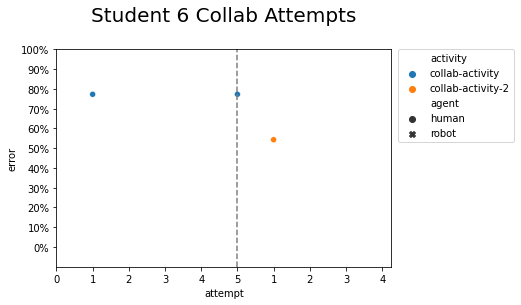

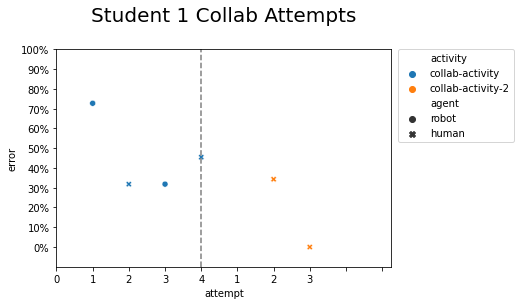

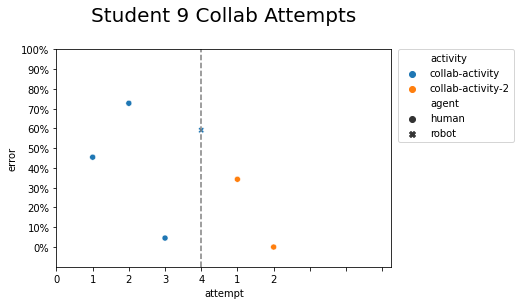

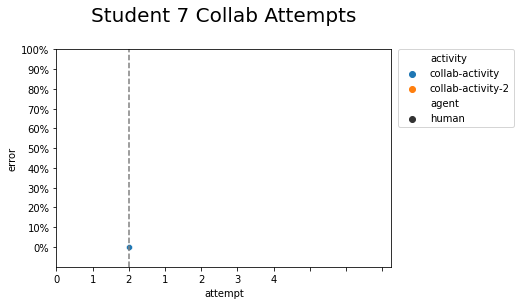

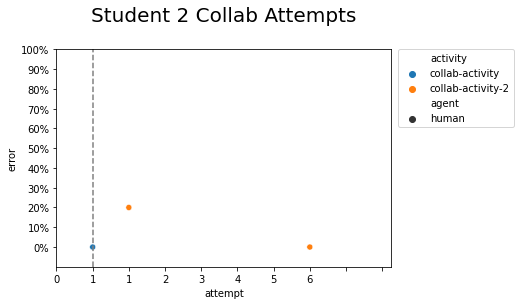

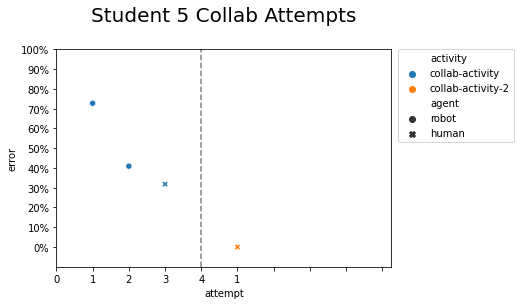

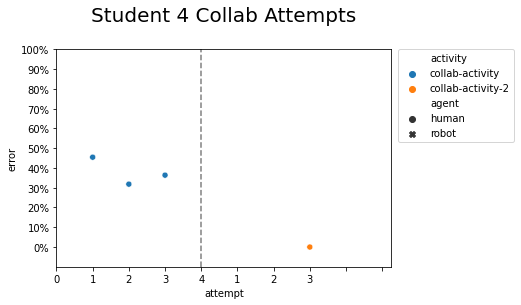

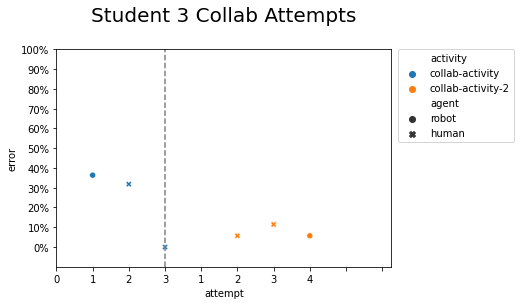

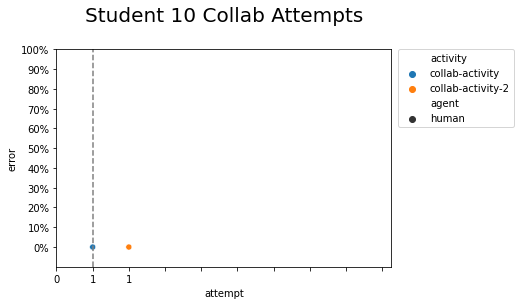

In [12]:
for student, df in collab_attempts.items():
    plt.figure()
    sns.scatterplot(data=df, x="attempt", y="error",
                    hue="activity", style="agent")
    plt.ylim(-0.1, 1)

    yticks = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
    plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    title = 'Student ' + str(int(df['student'][0])) + ' Collab Attempts\n'
    plt.title(title, loc='center', fontsize=20)

    # vertical line to divide plot by collaborative activity
    x = df.index[df['activity'] == 'collab-activity-2'].tolist()
    plt.axvline(x[0], 0, 1, ls='--', c='grey')

    # custom xticks for student attempts during each collab activity
#     t = df['attempt'].tolist()
    t = custom_xticks[student]
    t.insert(0, 0)
    plt.xlim(0.75, 9.25)
    plt.xticks(np.arange(0, 10, 1.0))

    plt.xticks(np.arange(0, 10, 1.0), labels=t)

# 3 Error over entire experiment evolution.

In [13]:
collab_best_copy = collab_best.copy()
# make dataframe for entire experiment for each student, using the best submissions of the collaborative activities
evolution_dfs = {}

for student,df in all_tables.items():
    print('student',student)
    # removing collaborative activity rows
    df = df[df['header.frame_id'] != "collab-activity"]
    df = df[df['header.frame_id'] != "collab-activity-2"]
    
    df.rename(columns={"header.frame_id": "activity",
                     "action.agent_name": "agent", "normalized_error": "error"}, inplace=True)
    
    # searching collab_best for collaborative activities of the student
    for index, row in collab_best_copy.iterrows():
        #if the student number of the best row matches the student
        if int(row['student']) == int(student):
            #then add the row of that student to the df
            df = df.append(row)
    
    # removing excess columns
    df.drop(columns=['world_state', 'is_submission', 'is_mst', 'cost', 'mst_cost', 'spanning', 'action'
                            ], inplace=True)
    
    # setting student column values
    df[['student']] = int(df.iloc[[-1][0]]['student'])
    
    #reset index
    df.reset_index(drop=True, inplace=True)
    
    #reorganizing dataframe so that collab activities are between tests
    posttests = df.loc[df['activity'].isin(['posttest-1','posttest-2','posttest-3','posttest-4','posttest-5'])]
    df = df.drop([5,6,7,8,9])
    df = df.append(posttests)
    df.reset_index(drop=True, inplace=True)
    
    #adding to dictionary
    evolution_dfs[student] = df
    display(df)
evolution_dfs


student 6


,activity,agent,error,student
0,pretest-1,human,0.266667,6
1,pretest-2,human,0.533333,6
2,pretest-3,human,0.238095,6
3,pretest-4,human,0.244444,6
4,pretest-5,human,0.266667,6
5,collab-activity,NaN,0.772727,6
6,collab-activity-2,NaN,0.542857,6
7,posttest-1,human,NaN,6
8,posttest-2,human,0.266667,6
9,posttest-3,human,0.238095,6


student 1


,activity,agent,error,student
0,pretest-1,human,0.533333,1
1,pretest-2,human,0.266667,1
2,pretest-3,human,0.047619,1
3,pretest-4,human,0.000000,1
4,pretest-5,human,0.000000,1
5,collab-activity,NaN,0.318182,1
6,collab-activity-2,NaN,0.000000,1
7,posttest-1,human,0.000000,1
8,posttest-2,human,0.000000,1
9,posttest-3,human,0.000000,1


student 9


,activity,agent,error,student
0,pretest-1,human,0.200000,9
1,pretest-2,human,1.600000,9
2,pretest-3,human,1.428571,9
3,pretest-4,human,1.200000,9
4,pretest-5,human,0.200000,9
5,collab-activity,NaN,0.045455,9
6,collab-activity-2,NaN,0.000000,9
7,posttest-1,human,0.133333,9
8,posttest-2,human,0.200000,9
9,posttest-3,human,0.095238,9


student 7


,activity,agent,error,student
0,pretest-1,human,0.2,7
1,pretest-2,human,0.0,7
2,pretest-3,human,NaN,7
3,pretest-4,human,NaN,7
4,pretest-5,human,NaN,7
5,collab-activity,NaN,0.0,7
6,collab-activity-2,NaN,NaN,7
7,posttest-1,human,NaN,7
8,posttest-2,human,NaN,7
9,posttest-3,human,NaN,7


student 2


,activity,agent,error,student
0,pretest-1,human,NaN,2
1,pretest-2,human,0.600000,2
2,pretest-3,human,0.285714,2
3,pretest-4,human,0.200000,2
4,pretest-5,human,0.466667,2
5,collab-activity,NaN,0.000000,2
6,collab-activity-2,NaN,0.000000,2
7,posttest-1,human,0.000000,2
8,posttest-2,human,0.000000,2
9,posttest-3,human,0.047619,2


student 5


,activity,agent,error,student
0,pretest-1,human,0.466667,5
1,pretest-2,human,0.266667,5
2,pretest-3,human,0.190476,5
3,pretest-4,human,0.377778,5
4,pretest-5,human,0.200000,5
5,collab-activity,NaN,0.318182,5
6,collab-activity-2,NaN,0.000000,5
7,posttest-1,human,0.266667,5
8,posttest-2,human,NaN,5
9,posttest-3,human,0.190476,5


student 4


,activity,agent,error,student
0,pretest-1,human,NaN,4
1,pretest-2,human,1.266667,4
2,pretest-3,human,0.238095,4
3,pretest-4,human,0.111111,4
4,pretest-5,human,0.333333,4
5,collab-activity,NaN,0.318182,4
6,collab-activity-2,NaN,0.000000,4
7,posttest-1,human,0.200000,4
8,posttest-2,human,0.400000,4
9,posttest-3,human,0.333333,4


student 3


,activity,agent,error,student
0,pretest-1,human,0.066667,3
1,pretest-2,human,0.066667,3
2,pretest-3,human,0.047619,3
3,pretest-4,human,0.022222,3
4,pretest-5,human,0.000000,3
5,collab-activity,NaN,0.000000,3
6,collab-activity-2,NaN,0.057143,3
7,posttest-1,human,0.000000,3
8,posttest-2,human,0.000000,3
9,posttest-3,human,0.000000,3


student 10


,activity,agent,error,student
0,pretest-1,human,0.066667,10
1,pretest-2,human,0.000000,10
2,pretest-3,human,0.000000,10
3,pretest-4,human,0.000000,10
4,pretest-5,human,0.000000,10
5,collab-activity,NaN,0.000000,10
6,collab-activity-2,NaN,0.000000,10
7,posttest-1,human,0.000000,10
8,posttest-2,human,0.000000,10
9,posttest-3,human,0.047619,10


{6:              activity  agent     error  student
 0           pretest-1  human  0.266667        6
 1           pretest-2  human  0.533333        6
 2           pretest-3  human  0.238095        6
 3           pretest-4  human  0.244444        6
 4           pretest-5  human  0.266667        6
 5     collab-activity    NaN  0.772727        6
 6   collab-activity-2    NaN  0.542857        6
 7          posttest-1  human       NaN        6
 8          posttest-2  human  0.266667        6
 9          posttest-3  human  0.238095        6
 10         posttest-4  human  0.177778        6
 11         posttest-5  human  0.066667        6,
 1:              activity  agent     error  student
 0           pretest-1  human  0.533333        1
 1           pretest-2  human  0.266667        1
 2           pretest-3  human  0.047619        1
 3           pretest-4  human  0.000000        1
 4           pretest-5  human  0.000000        1
 5     collab-activity    NaN  0.318182        1
 6   collab-a

# Visualizing student complete evolution.

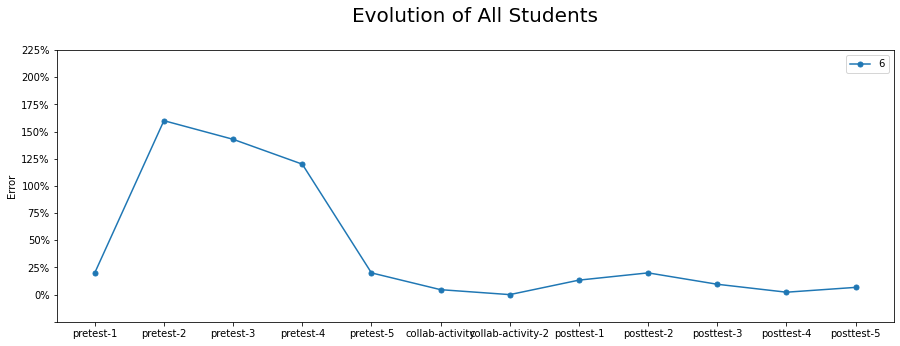

In [56]:
test = evolution_dfs[9]

# helper function to graph each student dataframe on same plot, takes dataframe as input
def generate_visualization(df):
    temp = df

    # visualization for error evolution over the best submission in each collaborative activity
    students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
    separation = 0.01

    # graphing the pretest versus posttest is_spanning scores
    plt.plot(temp.activity, temp.error, marker='o', markersize=5)
    fig = plt.gcf()
    fig.set_size_inches(15, 5)
    
    plt.ylabel('Error')
    title = "Evolution of All Students\n"
    plt.title(title, loc='center', fontsize=20)

    leg = plt.legend(evolution_dfs.keys(), loc='upper right', frameon=True)

    # ensure that y-axis labelling is proportional to maximum possible error 
    plt.ylim(-0.1, max_error[1])
    locs,labels = plt.yticks()
    labels = [str(round(i*100)) + '%' for i in locs]
    labels[0] = ''
    plt.yticks(locs,labels)

generate_visualization(test)

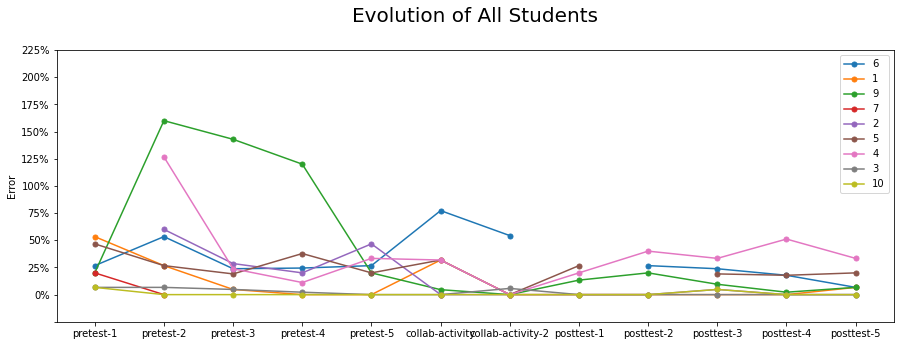

In [57]:
for student, df in evolution_dfs.items():
    generate_visualization(df)


# Descripitive statistics accross all activities.
- min max and mean (standard dev) duration & number of actions for every test/activity/attempt
    - box plots


# Find task intervals for all logs from their tables.
- slicers: put markers or checkpoints that point to the start and end of an activity
    - intervals dict for each student with start and end timestamps tuples
    - confirm the checkpoints: delete overlap and check contiguity and continuity
    
- One way to have a simpler check is to count number of transitions into that activity and move on if it is one, handle the case if it is more than one (for the case of going into and out from that activity).


In [92]:
# return the task interval times and handle cleaning from discontinuous log errors
def find_task_intervals(df, task):
    df = df.copy()
    df = df.loc[df['header.frame_id'] == task]
    start = df.iloc[0]['Time']
    end = df.iloc[-1]['Time']
    return start, end

headers = ['pretest-1', 'pretest-2', 'pretest-3', 'pretest-4', 'pretest-5', 'collab-activity',
           'collab-activity-2', 'posttest-1', 'posttest-2', 'posttest-3', 'posttest-4', 'posttest-5']

# log the start and end times of every task for every student
student_intervals = {}
for student, table in processed_tables.items():
    intervals = {}
    for i in headers:
        start, end = find_task_intervals(table.copy(), i)
        intervals[i] = (start, end)
    student_intervals[student] = intervals
#print(student_intervals)

for student,values in student_intervals.items():
    print(student, values)
    
    for test,times in values.items():
        start,end = values[test]
        print(start,end,'\n')
        
        #check the end time of pretest-1 with the start time of pretest-2
        #if above threshold of 
        break


6 {'pretest-1': (107.78392219543456, 167.10686135292053), 'pretest-2': (195.68815732002255, 230.0998957157135), 'pretest-3': (251.1525661945343, 289.6736686229706), 'pretest-4': (314.58395075798035, 360.7600588798523), 'pretest-5': (380.4511823654175, 423.1908950805664), 'collab-activity': (727.2702190876007, 2235.430909395218), 'collab-activity-2': (2282.949033498764, 3404.7349185943604), 'posttest-1': (3639.168105602264, 3670.641201496124), 'posttest-2': (3684.864453077316, 3714.0895581245422), 'posttest-3': (3726.333530187607, 3757.8723559379578), 'posttest-4': (3772.7371962070474, 3805.1794571876526), 'posttest-5': (3815.6659920215607, 3868.023068666458)}
107.78392219543456 167.10686135292053 

1 {'pretest-1': (96.4143397808075, 161.27743887901306), 'pretest-2': (184.98478150367737, 251.00974297523496), 'pretest-3': (273.7148389816284, 319.2249743938446), 'pretest-4': (341.8985347747803, 386.28241419792175), 'pretest-5': (404.6526141166687, 435.3684105873108), 'collab-activity': (4

In [117]:
def gantt_chart(df):
    
    # Declaring a figure "gnt" 
    fig, gnt = plt.subplots() 

    # Setting Y-axis limits 
    gnt.set_ylim(0, 100) 

    # Setting X-axis limits 
    gnt.set_xlim(0, 4000) 

    # Setting labels for x-axis and y-axis 
    gnt.set_xlabel('seconds since start') 
    gnt.set_ylabel('Activity') 

    # Setting ticks on y-axis 
    gnt.set_yticks([15, 25, 35, 45, 55, 65, 75, 85, 95,105,115,125]) 
    # Labelling tickes of y-axis 
    gnt.set_yticklabels(['pretest-1', 'pretest-2', 'pretest-3', 'pretest-4', 'pretest-5', 'collab-activity', 'collab-activity-2', 'posttest-1', 'posttest-2', 'posttest-3', 'posttest-4', 'posttest-5']) 

    # Setting graph attribute 
    gnt.grid(True) 

    # Declaring all the bars for each activity 
    for i in range(len(df)):
        gnt.broken_barh([(df.loc[i,'start'], df.loc[i,'duration'])], ((i+1)*10, 9), facecolors =('tab:red')) 

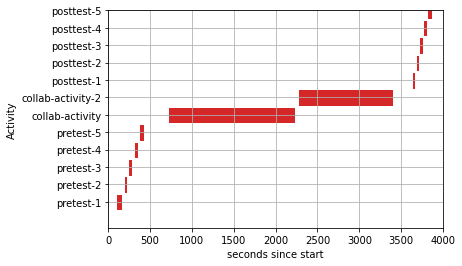

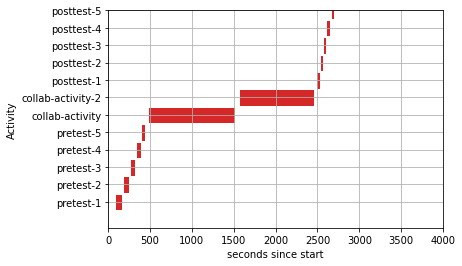

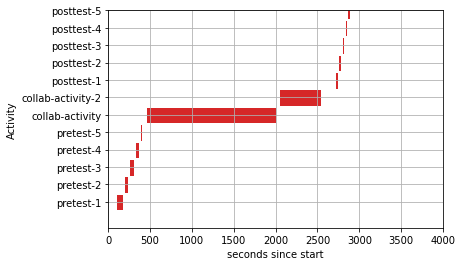

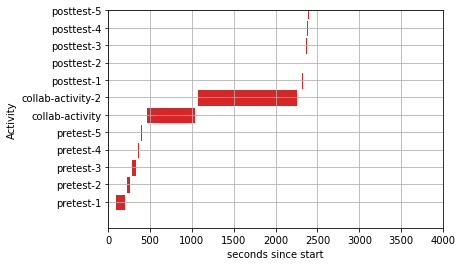

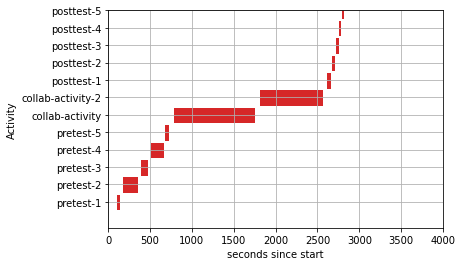

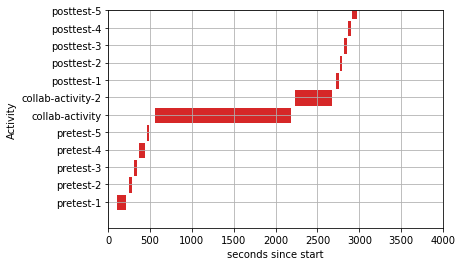

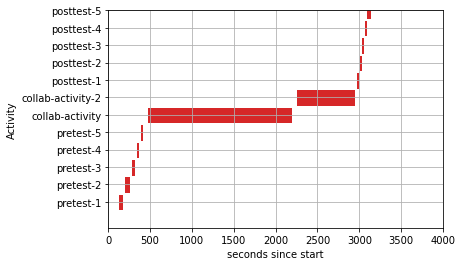

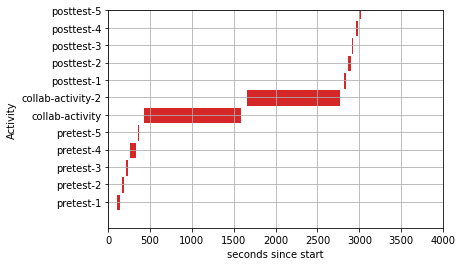

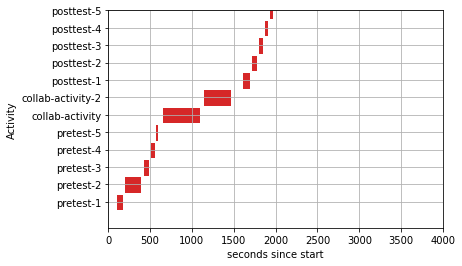

In [119]:
time_df = pd.DataFrame()

for student,values in student_intervals.items():
    #time_df = pd.DataFrame.from_dict(values)
    time_df['activity'] = values.keys()
    times = values.values()
    start = []
    end = []
    duration = []
    for i in times:
        s,e = i
        start.append(s)
        end.append(e) 
        duration.append(e-s)
    time_df['start'] = start
#     time_df['end'] = end
    time_df['duration'] = duration
#     display(time_df)
    
    gantt_chart(time_df)

In [17]:
# averaging normalized error for pretest and posttest
def compute_average_error(df):
    pre_total = 0
    post_total = 0
    pre_count = 0
    post_count = 0
    for index, row in df.iterrows():
        value = row['normalized_error']
        if 'pre' in row['header.frame_id']:
            # not computing the error for submissions that are not feasbile/spanning
            if not math.isnan(value):
                pre_total += value
                pre_count += 1
        elif 'post' in row['header.frame_id']:
            # not computing the error for submissions that are not feasbile/spanning
            if not math.isnan(value):
                post_total += value
                post_count += 1

    # compute averages while handling zero division
    if pre_count != 0:
        pre_avg = pre_total/pre_count
    else:
        pre_avg = None
    if post_count != 0:
        post_avg = post_total/post_count
    else:
        post_avg = None
    return pre_avg, post_avg


for key, table in all_tables.items():
    print('student', key)
    print('error averages: ',compute_average_error(table))

student 6
error averages:  (0.30984126984126986, 0.1873015873015873)
student 1
error averages:  (0.16952380952380955, 0.013333333333333332)
student 9
error averages:  (0.9257142857142858, 0.1034920634920635)
student 7
error averages:  (0.1, None)
student 2
error averages:  (0.38809523809523805, 0.009523809523809523)
student 5
error averages:  (0.3003174603174603, 0.2087301587301587)
student 4
error averages:  (0.4873015873015873, 0.3555555555555555)
student 3
error averages:  (0.040634920634920635, 0.0)
student 10
error averages:  (0.013333333333333332, 0.009523809523809523)
